In [1]:
import numpy as np
import matplotlib.pyplot as plt

Interpolamos el $\Phi$ real en los tiempos que calculamos el $\Phi$ con SIC:

In [2]:
T_REAL_PHI_FILE = "../data/t1_pps_aligned.bin" 
REAL_PHI_FILE = "../data/real_phi.bin"
T_SIC_PHI_FILE = "../data/t1.bin"

In [3]:
t_real_phi = np.fromfile(T_REAL_PHI_FILE)
real_phi = np.fromfile(REAL_PHI_FILE)
t_sic_phi = np.fromfile(T_SIC_PHI_FILE)

real_phi = np.interp(t_sic_phi,t_real_phi,real_phi)

real_phi.tofile("../data/real_phi_interp.bin")

In [4]:
from calc_mtie import mtie_calc
import numpy as np
import matplotlib.pyplot as plt

In [5]:
MTIE_WINDOW = 60
REAL_PHI_FILE = '../data/real_phi_interp.bin'
SIC_PHI_FILE = '../data/sic_phi.bin'
T_PPS_FILE = '../data/t1.bin'

In [6]:
real_phi = np.fromfile(REAL_PHI_FILE)
sic_phi = np.fromfile(SIC_PHI_FILE)
sic_phi = np.round(sic_phi)
t_pps = np.fromfile(T_PPS_FILE)

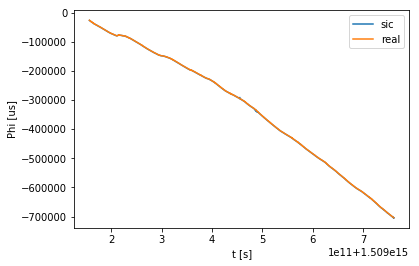

In [7]:
plt.plot(t_pps, sic_phi)
plt.plot(t_pps, real_phi)
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('sic','real'));

In [8]:
te = sic_phi - real_phi

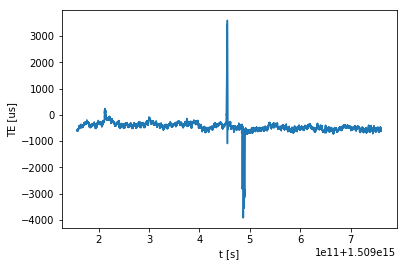

In [9]:
plt.plot(t_pps,te)
plt.xlabel('t [s]')
plt.ylabel('TE [us]');

In [10]:
tie, mtie = mtie_calc(te, MTIE_WINDOW)

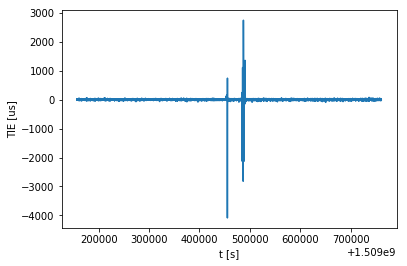

In [11]:
plt.plot(t_pps[:-MTIE_WINDOW]/1e6, tie)
plt.xlabel('t [s]')
plt.ylabel('TIE [us]');

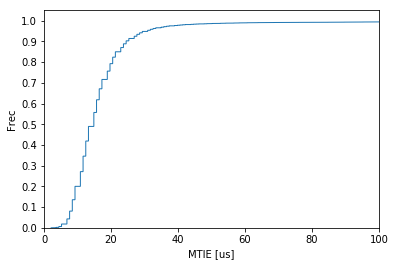

In [12]:
plt.hist(mtie, bins=5000, density=True, cumulative=True, histtype='step')
plt.xlabel('MTIE [us]')
plt.ylabel('Frec')
plt.xlim([0, 100])
plt.yticks([0.1*i for i in range(11)]);

In [13]:
print("PERCENTIL 90: ", np.percentile(mtie, 90), " us")

PERCENTIL 90:  24.999960999935865  us
